# Contrastive Model

In [1]:
%run utils.ipynb

In [2]:
import pandas as pd
import numpy as np
import os
import sys
# from utils import *
import matplotlib.pyplot as plt
%matplotlib inline
import dill

In [3]:
import sklearn
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, top_k_accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, make_pipeline

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, Input, Embedding, TextVectorization, Reshape, Add, Concatenate, Flatten, Conv1D, Conv1DTranspose
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [5]:
_, seg_df = load_user_data()
print(seg_df.shape)
y = pd.read_csv('challengeToFill.csv').drop(columns=['Unnamed: 0']).T.reset_index(drop=True).T
y_train = y.iloc[:LABELED_USERS, :TRAIN_SEG]
y_test = y.iloc[:LABELED_USERS, TRAIN_SEG:]
train_df = seg_df.iloc[:, :TRAIN_SEG]
test_df = seg_df.iloc[:LABELED_USERS, TRAIN_SEG:]
submission_df = seg_df.iloc[LABELED_USERS:, TRAIN_SEG:]
sentences = train_df.to_numpy().flatten().tolist()
embedding_model = create_embeddings(sentences, vector_size=EMBEDDING_DIM, window=5)
print(embedding_model.wv)
print(train_df.shape)
print(test_df.shape)

(40, 150)
FastTextKeyedVectors<vector_size=128, 228 keys>
(40, 50)
(10, 100)


In [6]:
tfidf_vec = TfidfVectorizer(ngram_range=(3,5), lowercase=False, min_df=0.1, max_df=1.0, sublinear_tf=True)
f = FunctionTransformer(lambda y: [' '.join(x) for x in y.to_numpy().flatten()])
etl_pipe = make_pipeline(f, tfidf_vec)
etl_pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x0000020188DD0C10>)),
                ('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, min_df=0.1,
                                 ngram_range=(3, 5), sublinear_tf=True))])

In [7]:
X_train = pd.DataFrame.sparse.from_spmatrix(etl_pipe.fit_transform(train_df), columns=tfidf_vec.get_feature_names_out())
X_train

,FIFO cat date,FIFO cat date generic,FIFO cat date generic generic,LOCK true ls,LOCK true ls sed,LOCK true ls sed FIFO,MediaMai sendmail launchef,cat date generic,cat date generic generic,cat date generic generic date,...,xconfirm endsessi tellwm,xhost xsetroot reaper,xhost xsetroot reaper cat,xhost xsetroot reaper cat mail,xprop endsessi xdm,xrdb mkpts env,xsetroot reaper cat,xsetroot reaper cat mail,xterm launchef sh,xterm launchef sh launchef
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.090908,0.091201,0.091496,0.094827,0.095157,0.095491,0.0,0.091201,0.091496,0.091795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.092185,0.092482,0.092782,0.096159,0.096494,0.096832,0.0,0.092482,0.092782,0.093084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.093468,0.093769,0.094073,0.097497,0.097836,0.098179,0.0,0.093769,0.094073,0.094379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.094401,0.094705,0.095012,0.098470,0.098813,0.099160,0.0,0.094705,0.095012,0.095322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
autoencoder = Sequential(
    [
        Input(shape=(X_train.shape[1])),
        Reshape((X_train.shape[1], 1)),
        # Embedding(vectorize_layer.vocabulary_size(), EMBEDDING_DIM),
        Conv1D(
            filters=32, kernel_size=5, padding="same", strides=1, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1D(
            filters=16, kernel_size=3, padding="same", strides=1, activation="relu"
        ),
        Conv1DTranspose(
            filters=16, kernel_size=3, padding="same", strides=1, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1DTranspose(
            filters=32, kernel_size=5, padding="same", strides=1, activation="relu"
        ),
        Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        Flatten()
    ], name='autoencoder')
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mae")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 176, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 176, 32)           192       
_________________________________________________________________
dropout (Dropout)            (None, 176, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 176, 16)           1552      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 176, 16)           784       
_________________________________________________________________
dropout_1 (Dropout)          (None, 176, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 176, 32)           

In [212]:
cp = ModelCheckpoint('model.h5', save_best_only=True, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=1)
rlop = ReduceLROnPlateau(patience=3, verbose=2)
callbacks = [cp, es, rlop]

In [213]:
history = autoencoder.fit(X_train, X_train, batch_size=128, epochs=20, validation_split=0.1, callbacks=callbacks)

Epoch 1/20
15/15 [==============================] - 3s 204ms/step - loss: 0.0037 - val_loss: 0.0017

Epoch 00001: val_loss improved from inf to 0.00165, saving model to model.h5
Epoch 2/20
15/15 [==============================] - 1s 50ms/step - loss: 0.0037 - val_loss: 0.0017

Epoch 00002: val_loss did not improve from 0.00165
Epoch 3/20
15/15 [==============================] - 2s 119ms/step - loss: 0.0037 - val_loss: 0.0017

Epoch 00003: val_loss did not improve from 0.00165
Epoch 4/20
15/15 [==============================] - 2s 122ms/step - loss: 0.0037 - val_loss: 0.0017

Epoch 00004: val_loss did not improve from 0.00165

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 5/20
15/15 [==============================] - 3s 181ms/step - loss: 0.0037 - val_loss: 0.0017

Epoch 00005: val_loss did not improve from 0.00165
Epoch 6/20
15/15 [==============================] - 3s 203ms/step - loss: 0.0037 - val_loss: 0.0017

Epoch 00006: val_loss did not im

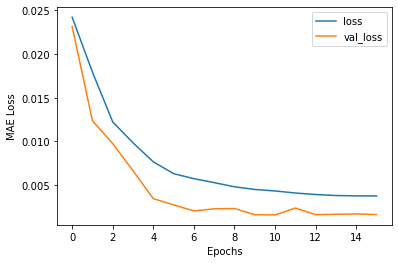

In [202]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [203]:
s_test = pd.Series(test_df.to_numpy().flatten()).apply(lambda x: ' '.join(x)).values.reshape(-1, 1).tolist()
test = np.expand_dims(vectorize_layer(s_test), -1)
test.shape

(1000, 100, 1)

In [204]:
X_test = pd.DataFrame.sparse.from_spmatrix(etl_pipe.transform(test_df), columns=tfidf_vec.get_feature_names_out())
X_test

,FIFO cat date,FIFO cat date generic,FIFO cat date generic generic,LOCK true ls,LOCK true ls sed,LOCK true ls sed FIFO,MediaMai sendmail launchef,cat date generic,cat date generic generic,cat date generic generic date,...,xconfirm endsessi tellwm,xhost xsetroot reaper,xhost xsetroot reaper cat,xhost xsetroot reaper cat mail,xprop endsessi xdm,xrdb mkpts env,xsetroot reaper cat,xsetroot reaper cat mail,xterm launchef sh,xterm launchef sh launchef
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
def find_threshold(model, x_train):
    reconstructions = model.predict(x_train)
    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.mae(reconstructions, x_train)
    # threshold for anomaly scores
    threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
    return threshold

def get_predictions(model, x_test, threshold):
    predictions = model.predict(x_test)
    # provides losses of individual instances
    errors = tf.keras.losses.mae(predictions, x_test)
    # 0 = anomaly, 1 = normal
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
    return preds

In [206]:
threshold = find_threshold(autoencoder, X_test)
print(f"Threshold: {threshold}")
predictions = get_predictions(autoencoder, X_test, threshold)
# print(predictions)
accuracy_score(predictions, y_test.to_numpy().flatten())

Threshold: 0.002728971681320449


0.242

In [207]:
get_metrics(y_test.to_numpy().flatten(), predictions)

Acc: 0.242
Precision: 0.10551558752997602
Recall: 0.88
F1 Score: 0.18843683083511775
Classification Score: 946
Final Grade: 58.93114754098361


58.93114754098361

In [226]:
encoder = Sequential([
    Input(shape=(X_train.shape[1])),
    Reshape((X_train.shape[1], 1)),
    # Embedding(vectorize_layer.vocabulary_size(), EMBEDDING_DIM),
    Conv1D(
        filters=32, kernel_size=5, strides=1, activation="relu"
    ),
    Dropout(rate=0.2),
    Conv1D(
        filters=16, kernel_size=3, strides=1, activation="relu"
    )
], name='encoder')
# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mae")
encoder.build()
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_30 (Reshape)         (None, 176, 1)            0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 172, 32)           192       
_________________________________________________________________
dropout_91 (Dropout)         (None, 172, 32)           0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 170, 16)           1552      
Total params: 1,744
Trainable params: 1,744
Non-trainable params: 0
_________________________________________________________________


In [216]:
decoder = Sequential([
    Conv1DTranspose(
        filters=16, kernel_size=3, padding="same", strides=1, activation="relu"
    ),
    Dropout(rate=0.2),
    Conv1DTranspose(
        filters=32, kernel_size=5, padding="same", strides=1, activation="relu"
    ),
    Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    Flatten()
])